# Face2Emoji

- The model is trained on the FER2013 dataset which consists of 48x48 pixel grayscale images of faces (approximately 30,000 images, with 7 emotions).
- The model is able to predict the relevant emoji for the given facial expression in the image.

## 📦 Installation
To install the required packages, run the following command:
```bash
pip install -r requirements.txt
```

In [ ]:
#!pip install -r requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import torch
import pytorch_lightning as pl
from transformers import ViTForImageClassification
from huggingface_hub import notebook_login
from peft import PeftModel, PeftConfig


from src import lightning_model
from src.data import get_dataloaders

# Fix seed
pl.seed_everything(0, workers=True)

Seed set to 0


0

## 📚 Dataset
Dataset used for training the model is FER2013 dataset. The dataset contains approx. 30,000 images that are each annotated with one of 7 emotions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
Training pipeline expects the dataset to be in the following structure:
```bash
root
└── dataset
        └── fer2013.csv
        
```
You can download the dataset from the following link:
```bash
wget -P ./dataset https://huggingface.co/spaces/mxz/emtion/blob/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv
```


In [5]:
if not os.path.exists('dataset/fer2013.csv'):
    !wget -P ./dataset https://huggingface.co/spaces/mxz/emtion/blob/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv
    !echo 'Downloaded FER2013 dataset successfully.'

train_loader, val_loader, test_loader, emotion_mapping = get_dataloaders(path='dataset/fer2013.csv', bs=16, augment=True)

## 🤖 Model
The model is Vision Transformer (ViT) which is a transformer model that performs very well on image classification tasks.  
The pre-trained model from 🤗 Hugging Face can be fine-tuned on the FER2013 dataset using Low-Rank Adaption (LoRA).  
LoRA is a technique that fine-tunes a pre-trained model by adding a small trainable weight matrix, while keeping the original model weights frozen.

Comparison of each model's performance is shown below:
| Method | Trainable Params | VRAM | Batch Size | Epoch | val_acc | lr | 
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
| LoRA | 1.3 M (1.52 %) | 1.5 GB | 16 | 9 epochs | 71.22 % | 1e-3 | 
| FT | 85.8 M (100 %) | 4 GB | 16 | 6 epochs | 71.89% | 2e-5 |

In conclusion, the LoRA method utilizes 1/3 of the VRAM compared to the FT method. Although it exhibits slightly lower validation accuracy, it represents a favorable trade-off between the number of parameters and validation accuracy.

In [ ]:
model = lightning_model.BaseModel(model_name='google/vit-base-patch16-224-in21k', trainable=True, num_classes=7, lora=False, lr=2e-4, weight_decay=0.0, optimizer='Adam')

## 🏃 Training

In [ ]:
trainer = pl.Trainer(max_epochs=30,
                    enable_checkpointing=False, 
                    callbacks=[lightning_model.OverrideEpochStepCallback(),
                                pl.callbacks.EarlyStopping(monitor='val/loss', patience=5, verbose=False),
                                #pl.callbacks.ModelCheckpoint(monitor='val/loss', filename='best_model_{epoch:02d}', mode='min')
                                ]
                    )
trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer.test(model, test_loader)
print(classification_report(model.test_outputs['y_true'], model.test_outputs['y_pred'], target_names=emotion_mapping.values()))

In [ ]:
%load_ext tensorboard
%tensorboard  --logdir lightning_logs/

## ⚖ Save Weights

In [ ]:
# # save the lora layer to the hub
# notebook_login()
# model.model.model.push_to_hub('vit-fer2013')

In [ ]:
# # save the lora layer to the hub
# notebook_login()
# model.model.model.push_to_hub('vit-lora-fer2013')

# # save the head weights
# torch.save(model.model.model.classifier.state_dict(), 'model_weights/vit-head-fer2013.pth')

## ⏳️ Inference

In [3]:
model = ViTForImageClassification.from_pretrained('yosshstd/vit-fer2013')

In [ ]:
# load trained model
# peft_model_id = 'yosshstd/vit-lora-fer2013'
# config = PeftConfig.from_pretrained(peft_model_id)
# model = ViTForImageClassification.from_pretrained(config.base_model_name_or_path, num_labels=7)
# model.classifier.load_state_dict(torch.load('model_weights/vit-head-fer2013.pth'))

# peft_model = PeftModel.from_pretrained(model, peft_model_id)

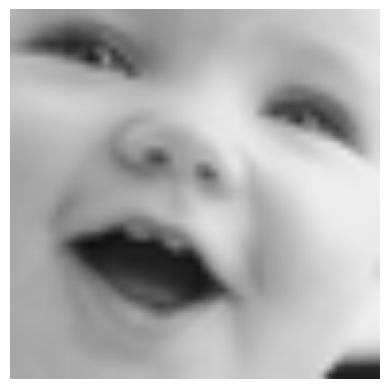

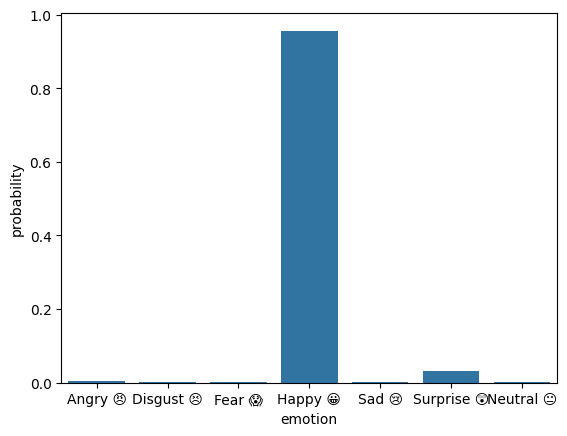

Ground truth: Happy 😀
Prediction: Happy 😀


In [7]:
# Fetch a batch of images
X, y = next(iter(test_loader))
id = 10

# Forward pass
model.eval()
with torch.no_grad():
    logits = model(X[id].unsqueeze(0).to(model.device))

# apply softmax
probs = torch.nn.functional.softmax(logits[0], dim=1)

# Display the image

X = X / 2 + 0.5
plt.imshow(np.transpose(X[id].numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

# Display the probabilities in a bar plot
df = pd.DataFrame({'emotion': [emotion_mapping[i] for i in range(7)], 'probability': probs[0].cpu().numpy()})
sns.barplot(x='emotion', y='probability', data=df)
plt.show()

# gt
print(f'Ground truth: {df.loc[y[id].item()]["emotion"]}')
# prediction
print(f'Prediction: {df.loc[probs.argmax().item()]["emotion"]}')


## Emotion feature space visualization

- The ViT embeddings of the images in the FER2013 dataset are dimensionally reduced to 2D using UMAP and visualized in a scatter plot. 
- The plot shows that the embeddings of the images annotated with the same emotion are clustered together, which indicates that the model has learned to represent the emotions in a meaningful way.

In [8]:
# load
umap_embeddings = pd.read_csv('embedding/umap_embeddings_2d.csv').values

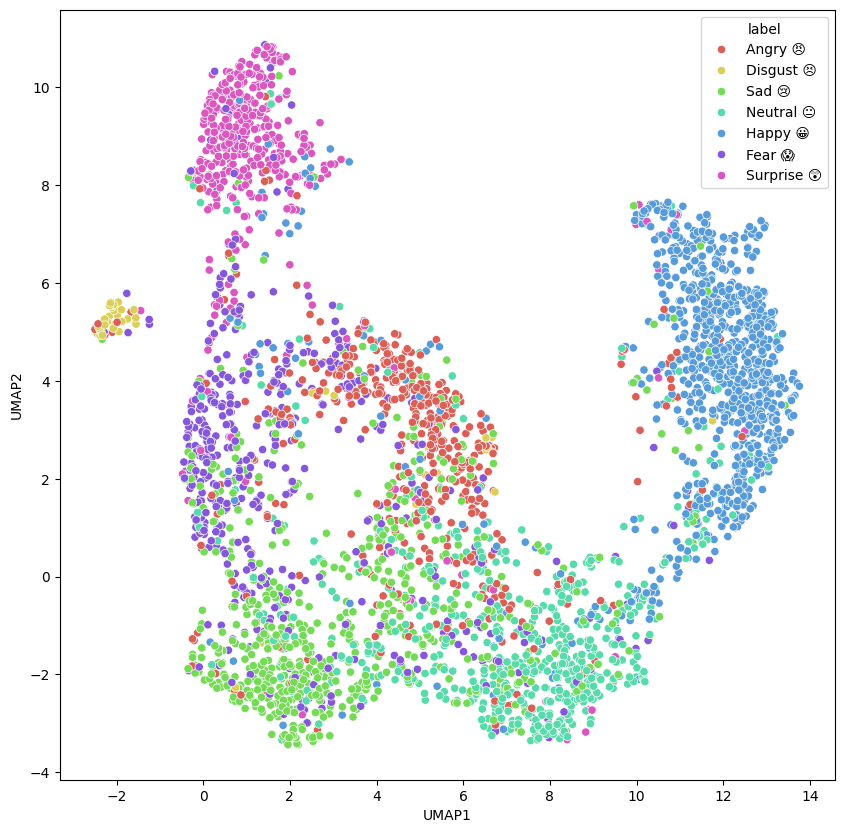

In [9]:
# Create a dataframe for visualization
data = {'UMAP1': umap_embeddings[:, 0], 'UMAP2': umap_embeddings[:, 1], 'label': [emotion_mapping[l] for l in umap_embeddings[:, 2]]}
df = pd.DataFrame(data)

# Visualize the embeddings
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='label', palette=sns.color_palette('hls', 7))
plt.show()

## 📝 Refferences
- [ViT Paper](https://arxiv.org/abs/2010.11929)
- [LoRA Paper](https://arxiv.org/abs/2106.09685)
- [FER2013 Dataset](https://paperswithcode.com/dataset/fer2013)

## ☑️ To-Do
- Emotion feature space visualization